# Using LinearDiscriminantAnalysis()

In [74]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pandas as pd
from PIL import Image
import clip
import numpy as np

# Load CSV file
csv_path = 'cat_dog1.csv'
df = pd.read_csv(csv_path)

# Assuming your CSV has 'image' and 'labels' columns
images = df['image'].values
labels = df['labels'].values

# Split the dataset
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, transform = clip.load("ViT-B/32", device=device)

# Utilize the CLIP model to extract embeddings for each image in the dataset (both train and test dataset)
train_embeddings = []
test_embeddings = []

for image_path, label in zip(train_images, train_labels):
    # Load image using PIL and apply transformations
    image = transform(Image.open(image_path)).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model.encode_image(image)
    train_embeddings.append(embedding.cpu().numpy())

for image_path, label in zip(test_images, test_labels):
    # Load image using PIL and apply transformations
    image = transform(Image.open(image_path)).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model.encode_image(image)
    test_embeddings.append(embedding.cpu().numpy())

# Organize the extracted CLIP embeddings into a feature matrix
train_features = np.concatenate(train_embeddings)
test_features = np.concatenate(test_embeddings)
feature_matrix = torch.cat((train_embeddings, test_embeddings), dim=0)

# Fisher Algorithm
lda = LinearDiscriminantAnalysis()
lda.fit(train_features, train_labels)


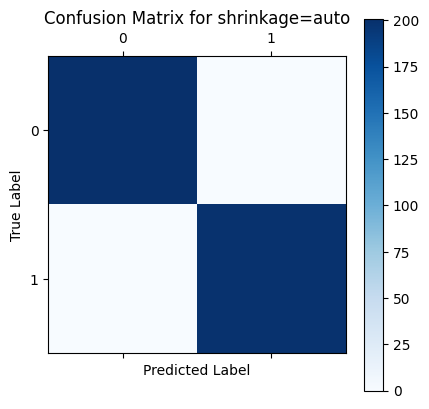

Confusion Matrix:
[[201   0]
 [  0 199]]

Metrics for shrinkage=auto:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0


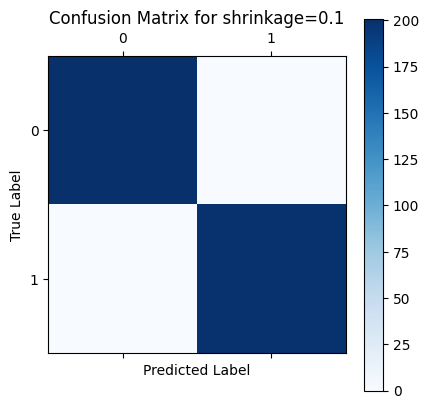

Confusion Matrix:
[[201   0]
 [  0 199]]

Metrics for shrinkage=0.1:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0


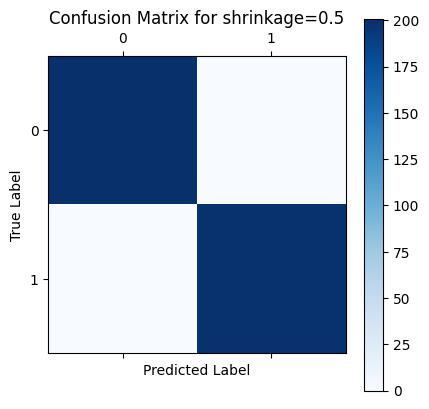

Confusion Matrix:
[[201   0]
 [  0 199]]

Metrics for shrinkage=0.5:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0


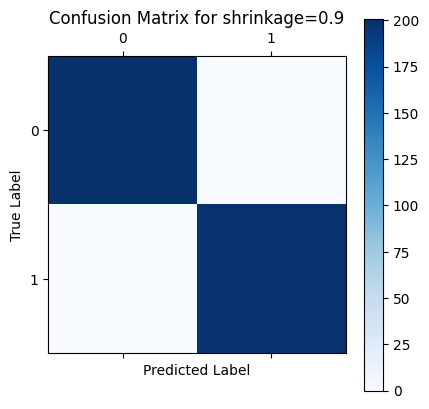

Confusion Matrix:
[[201   0]
 [  0 199]]

Metrics for shrinkage=0.9:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Best shrinkage value: auto with Accuracy: 1.0


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Define the values for the parameter shrinkage
shrinkage_values = ['auto', 0.1, 0.5, 0.9]

# Initialize variables for tracking the best model
best_accuracy = 0.0
best_shrinkage = None


for shrinkage in shrinkage_values:
    fisher_model = LinearDiscriminantAnalysis(solver='eigen', shrinkage=shrinkage)
    fisher_model.fit(train_features, train_labels)

    # Test the model using the testing dataset and visualize the classification results using a confusion matrix
    predictions = fisher_model.predict(test_features)
    confusion_mat = confusion_matrix(test_labels, predictions)

    # Visualize the confusion matrix
    plt.matshow(confusion_mat, cmap='Blues')
    plt.colorbar()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for shrinkage={shrinkage}')
    plt.show()

    # Print the confusion matrix values
    print("Confusion Matrix:")
    print(confusion_mat)

    # Model Evaluation
    accuracy = accuracy_score(test_labels, predictions)
    precision = precision_score(test_labels, predictions)
    recall = recall_score(test_labels, predictions)
    f1 = f1_score(test_labels, predictions)
 
    print(f"\nMetrics for shrinkage={shrinkage}:")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)

    # Check if the current model is the best based on accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_shrinkage = shrinkage

print(f"\nBest shrinkage value: {best_shrinkage} with Accuracy: {best_accuracy}")


# Manual implementation with equation

In [1]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pandas as pd
from PIL import Image
import clip
import numpy as np

# Load CSV file
csv_path = 'cat_dog1.csv'
df = pd.read_csv(csv_path)

# Assuming your CSV has 'image' and 'labels' columns
images = df['image'].values
labels = df['labels'].values

# Split the dataset
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, transform = clip.load("ViT-B/32", device=device)



In [2]:

# Utilize the CLIP model to extract embeddings for each image in the dataset (both train and test dataset)
train_embeddings = []
test_embeddings = []

for image_path, label in zip(train_images, train_labels):
    # Load image using PIL and apply transformations
    image = transform(Image.open(image_path)).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model.encode_image(image)
    train_embeddings.append(embedding.cpu().numpy())

for image_path, label in zip(test_images, test_labels):
    # Load image using PIL and apply transformations
    image = transform(Image.open(image_path)).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model.encode_image(image)
    test_embeddings.append(embedding.cpu().numpy())

In [43]:
train_features = torch.from_numpy(np.concatenate(train_embeddings))
test_features = torch.from_numpy(np.concatenate(test_embeddings))

feature_matrix = torch.cat((train_features, test_features), dim=0)


In [45]:
import itertools
def fisher_discriminant(feature_matrix, labels, C):
    # Convert labels to PyTorch tensor
    labels_tensor = torch.tensor(labels)

    # Calculate class means
    class_means = torch.zeros(len(torch.unique(labels_tensor)), feature_matrix.shape[1])
    for label, embeddings in zip(labels_tensor, feature_matrix):
        class_means[label] += embeddings

    class_means /= torch.bincount(labels_tensor).unsqueeze(1)

    # Calculate within-class scatter matrix
    Sw = torch.zeros(feature_matrix.shape[1], feature_matrix.shape[1])
    for label, embedding in zip(labels_tensor, feature_matrix):
        diff = embedding - class_means[label]
        Sw += torch.outer(diff, diff)

    # Add regularization term to Sw
    Sw += C * torch.eye(Sw.shape[0])

    # Calculate between-class scatter matrix
    Sb = torch.zeros(feature_matrix.shape[1], feature_matrix.shape[1])
    for mean1, mean2 in itertools.combinations(class_means, 2):
        diff = mean1 - mean2
        Sb += torch.outer(diff, diff)

    # Calculate Fisher discriminant
    w = torch.inverse(Sw) @ Sb @ (class_means[1] - class_means[0])
    w /= C

    return w

# Train Fisher model with regularization
C = 0.1  
w_fisher = fisher_discriminant(feature_matrix[:len(train_features)], labels[:len(train_features)], C)

c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


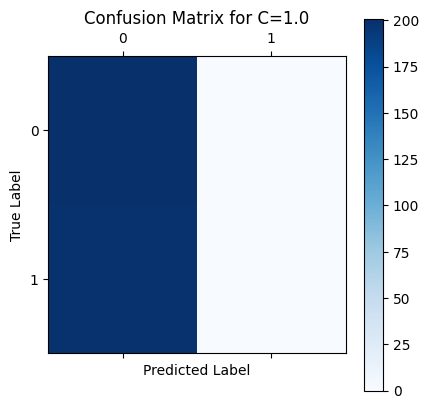

[[201   0]
 [199   0]]
Accuracy: 0.5025
Precision: 0.0
Recall: 0.0
F1-score: 0.0


In [87]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
def predict(embeddings, w_fisher, threshold=0.5): #made threshold=0.5 but wasnt balanced so made it less than 0.5 to decrease FP results are in report
    scores = torch.matmul(embeddings, w_fisher)
    predictions = (scores > threshold).long()
    
    return predictions

# Predict on the test set
test_predictions = predict(feature_matrix[len(train_embeddings):], w_fisher)

y_test = test_labels 

# Calculate confusion matrix and metrics
confusion_matrix_test = confusion_matrix(y_test, test_predictions)
accuracy = accuracy_score(y_test, test_predictions)
precision = precision_score(y_test, test_predictions)
recall = recall_score(y_test, test_predictions)
f1 = f1_score(y_test, test_predictions)


# Visualize the confusion matrix
plt.matshow(confusion_matrix_test, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix for C={C}')
plt.show()
    
# Print metrics
print(confusion_matrix_test)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

# Change C values in Manual Implementation

c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


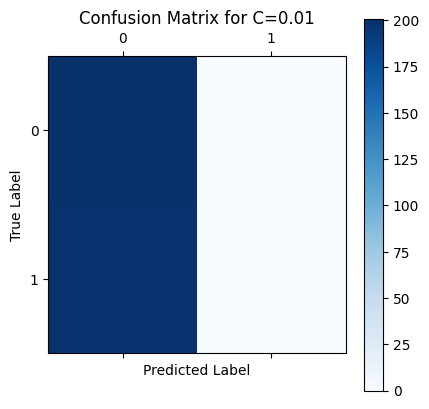

[[201   0]
 [199   0]]
Accuracy: 0.5025
Precision: 0.0
Recall: 0.0
F1-score: 0.0


c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


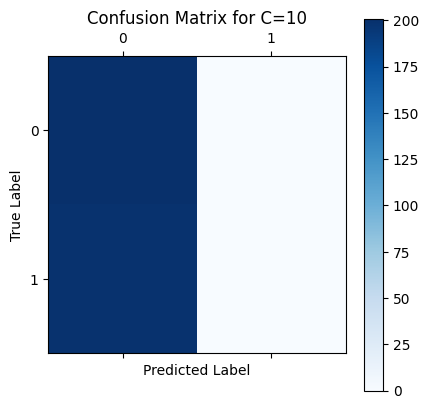

[[201   0]
 [199   0]]
Accuracy: 0.5025
Precision: 0.0
Recall: 0.0
F1-score: 0.0


c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


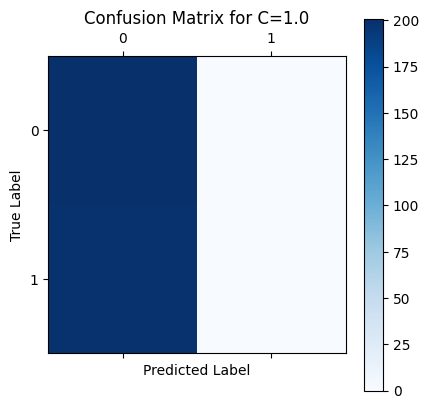

[[201   0]
 [199   0]]
Accuracy: 0.5025
Precision: 0.0
Recall: 0.0
F1-score: 0.0
Best C: 0.01 with accuracy: 0.5025


In [85]:
C_values = [0.01, 10, 1.0]
best_accuracy = 0
best_C = None
for C in C_values:
    w_fisher_C = fisher_discriminant(feature_matrix[:len(train_features)], labels[:len(train_features)], C)
    test_predictions_C = predict(feature_matrix[len(train_embeddings):], w_fisher_C)
    
    
    y_test = test_labels  

     # Calculate confusion matrix and metrics
    confusion_matrix_test_C = confusion_matrix(y_test, test_predictions_C)
    accuracy_C = accuracy_score(y_test, test_predictions_C)
    precision_C = precision_score(y_test, test_predictions_C)
    recall_C = recall_score(y_test, test_predictions_C)
    f1_C = f1_score(y_test, test_predictions_C)

    # Visualize the confusion matrix
    plt.matshow(confusion_matrix_test, cmap='Blues')
    plt.colorbar()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for C={C}')
    plt.show()
        
    # Print metrics
    print(confusion_matrix_test)
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-score: {f1}")


    if accuracy_C > best_accuracy:
        best_accuracy = accuracy_C
        best_C = C

print(f"Best C: {best_C} with accuracy: {best_accuracy}")
